In [1]:
import os
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.utils import load_img
import numpy as np
import pandas as pd
from keras.layers import Dense
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/Assn_5/'
os.chdir(path)

Mounted at /content/drive


In [3]:
%%script echo skip
!unzip Group_20.zip 

skip


In [4]:
!ls

 Group_20       sequential-model-weights   test1.csv	    weights
 Group_20.zip   temp_weight-test.csv	  'vgg19-(1).png'


In [5]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [6]:
vgg19 = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    classes=1000,
    classifier_activation="softmax"
)

574710816/574710816 [==============================] - 6s 0us/step


In [7]:
print(vgg19.summary())

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
%%script echo skip
plot_model(vgg19, show_shapes=False, show_layer_activations=True, to_file='vgg19-(1).png')

skip


In [9]:
%%script echo skip
for i, hl in enumerate(vgg19.layers):
    print(i, " ", hl.name)

skip


In [10]:
## create a new layer and add weights to it
vgg19_transfer = tf.keras.models.Sequential() #name=transfer_learning
for i in range(len(vgg19.layers) - 1):
    vgg19_transfer.add(vgg19.layers[i])

In [11]:
# freeze all the convolution layers in training
for hl in vgg19.layers:
    hl.trainable = False

In [12]:
# add a new classification/output layer
vgg19_transfer.add(Dense(5, activation = 'softmax', kernel_initializer=glorot_normal(seed=42), name='output_layer'))

In [13]:
vgg19_transfer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

### Save layer weight callback 

In [14]:
# Define the layers whose weights you want to save
layer_names = ['output_layer']

# Define the custom callback function to save the weights of specific layers
class SaveLayerWeightsCallback(ModelCheckpoint):
    def __init__(self, filepath, layers, **kwargs):
        self.layers = layers
        self.filepath = filepath
        super().__init__(filepath, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        for layer_name in self.layers:
            layer = self.model.get_layer(layer_name)
            weights = layer.get_weights()
            if not os.path.exists(self.filepath):
              os.mkdir(self.filepath)
            filename1 = f"{layer_name}_epoch_{epoch}_weights.csv"
            filename2 = f"{layer_name}_epoch_{epoch}_bias.csv"
            filepath1 = os.path.join(self.filepath, filename1)
            filepath2 = os.path.join(self.filepath, filename2)
            # layer.save_weights(filepath)
            pd.DataFrame(weights[0]).to_csv(filepath1, index=False)
            pd.DataFrame(np.array([weights[1]])).to_csv(filepath2, index=False)
            # pd.DataFrame(weights).to_csv(filepath) # this saves array as a string and which is problamatic



In [15]:
threshold_val = 0.0001
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  min_delta=threshold_val,
                                                  mode='min',
                                                  restore_best_weights=True, 
                                                  verbose=1)

In [16]:
# Create an instance of the custom callback
save_layer_weights = SaveLayerWeightsCallback(filepath='sequential-model-weights/', layers=layer_names)

In [17]:
lr=1e-3
epsilon_val=1e-8
beta1=0.9
beta2=0.999

In [18]:
vgg19_transfer.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                       optimizer=keras.optimizers.Adam(learning_rate=lr,
                                                       epsilon=epsilon_val,
                                                       beta_1=beta1,
                                                       beta_2=beta2),
                        metrics=['accuracy'])

In [19]:
%%script echo skip
plot_model(vgg19_transfer, show_shapes=False, show_layer_activations=True)

skip


In [20]:
curr_path = os.getcwd()
random_seed =42

In [21]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Read datasets

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    curr_path + '/Group_20/train/',
    batch_size=32,
    seed = random_seed,
    image_size=(224, 224)
).map(lambda x, y: (normalization_layer(x), y))

Found 250 files belonging to 5 classes.


In [23]:
# load validation dataset 
valid_ds = tf.keras.utils.image_dataset_from_directory(
    curr_path + '/Group_20/val/',
    batch_size=32,
    seed = random_seed,
    image_size=(224, 224)
).map(lambda x, y: (normalization_layer(x), y))

Found 50 files belonging to 5 classes.


In [37]:
# load test dataset 
test_ds = tf.keras.utils.image_dataset_from_directory(
    curr_path + '/Group_20/test/',
    batch_size=32,
    seed = random_seed,
    image_size=(224, 224)
).map(lambda x, y: (normalization_layer(x), y))

Found 100 files belonging to 5 classes.


In [38]:
%%script echo skip
history_vgg19 = vgg19_transfer.fit(train_ds,
                                epochs=50,
                                batch_size=32,
                                validation_data=valid_ds,
                                callbacks=[save_layer_weights, early_stopping]
                                )

skip


In [39]:
best_w = pd.read_csv('sequential-model-weights/output_layer_epoch_2_weights.csv', dtype='float32').values
best_b = pd.read_csv('sequential-model-weights/output_layer_epoch_2_bias.csv', dtype='float32').values[0]

In [40]:
## load model
vgg19_transfer.get_layer('output_layer').set_weights([best_w, best_b])

### Transfer learning summary 
- best model weights is achieved in epoch 3





In [41]:
vgg19_transfer.predict(test_ds).argmax(axis=1)

4/4 [==============================] - 24s 433ms/step


array([2, 2, 1, 4, 4, 4, 0, 1, 4, 1, 4, 4, 1, 2, 1, 4, 2, 1, 4, 2, 1, 0,
       2, 4, 4, 2, 0, 0, 3, 1, 3, 0, 2, 1, 0, 1, 1, 1, 4, 4, 3, 2, 3, 4,
       0, 0, 3, 2, 1, 4, 3, 0, 0, 2, 2, 3, 1, 3, 0, 1, 0, 3, 2, 0, 1, 3,
       3, 3, 0, 1, 2, 0, 4, 1, 0, 3, 4, 2, 1, 3, 1, 1, 1, 3, 3, 3, 2, 4,
       0, 1, 4, 1, 0, 0, 3, 2, 2, 4, 4, 3])

In [42]:
test_loss, test_acc = vgg19_transfer.evaluate(test_ds, verbose=0)
print("test accuracy = ", test_acc)
print("test loss ", test_loss)

test accuracy =  0.9599999785423279
test loss  0.11188392341136932


In [43]:
_, train_acc = vgg19_transfer.evaluate(train_ds, verbose=0)
_, val_acc = vgg19_transfer.evaluate(valid_ds, verbose=0)
print(f"training accuracy = {train_acc :.3f}")
print(f"validation accuracy = {val_acc :.3f}" )

training accuracy = 1.000
validation accuracy = 0.980


### Loading saved model 
- checking if our model has been saved correctly or not

In [44]:
%%script echo skip
best_op_wb = vgg19_transfer.get_layer('output_layer').get_weights()
sum(pd.read_csv('sequential-model-weights/output_layer_epoch_2_weights.csv', dtype='float32').values == best_op_wb[0])

skip


- We can see that the our saved weights are exactly matching with the current best weights here epoch = 3(epoch idx=2)

### Confusion Matrix plot

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [46]:
import itertools

In [75]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=10): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # overall accuracy
  true_cls = 0
  for i in range(cm.shape[0]):
    true_cls += cm[i][i]
  acc_all = (true_cls/len(y_true))*100

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  # fig.colorbar(cax) # for now skip plotting heat index

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes 
  ax.set(title=f"Confusion Matrix\naccuracy: {acc_all}",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [70]:
def plot_confusion_matrix(data_set, label_names):
  # Get true labels
  true_labels = []
  predicted_ =[]
  for images, labels in data_set:
    true_labels += labels.numpy().tolist()
    predicted_ += vgg19_transfer.predict(images, verbose=0).argmax(axis=1).tolist()
  make_confusion_matrix(true_labels, predicted_, label_names)


plotting confusion matrix with classes

In [69]:
class_names = ['brain', 'butterfly', 'ewer', 'helicopter', 'ketch']

                    |------------------- confusion matrix for training datasets --------------|



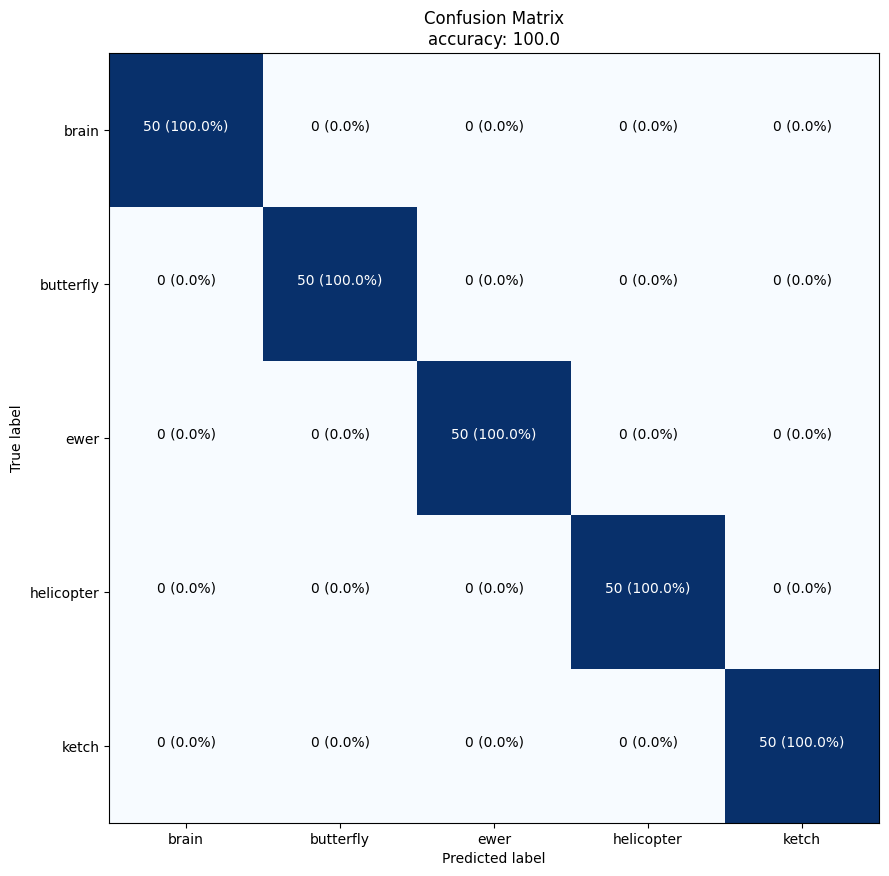

In [82]:
print('                    |------------------- confusion matrix for training datasets --------------|')
print()
plot_confusion_matrix(train_ds, class_names)

                    |------------------- confusion matrix for validation datasets --------------|



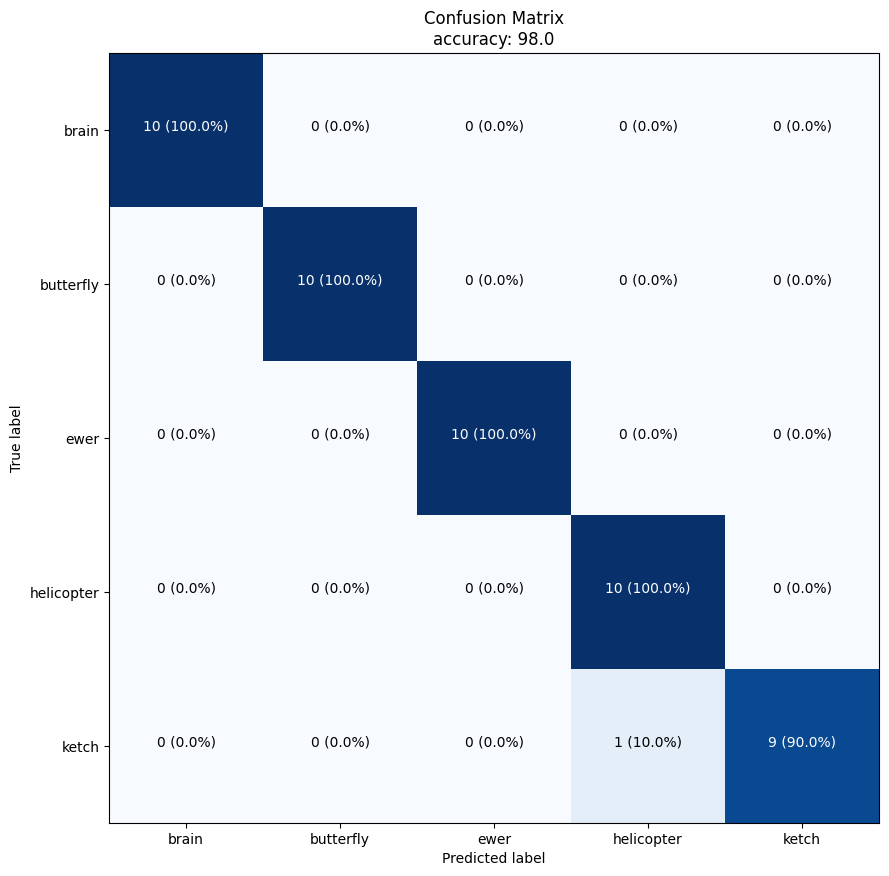

In [81]:
print('                    |------------------- confusion matrix for validation datasets --------------|')
print()
plot_confusion_matrix(valid_ds, class_names)

                    |------------------- confusion matrix for test datasets --------------|



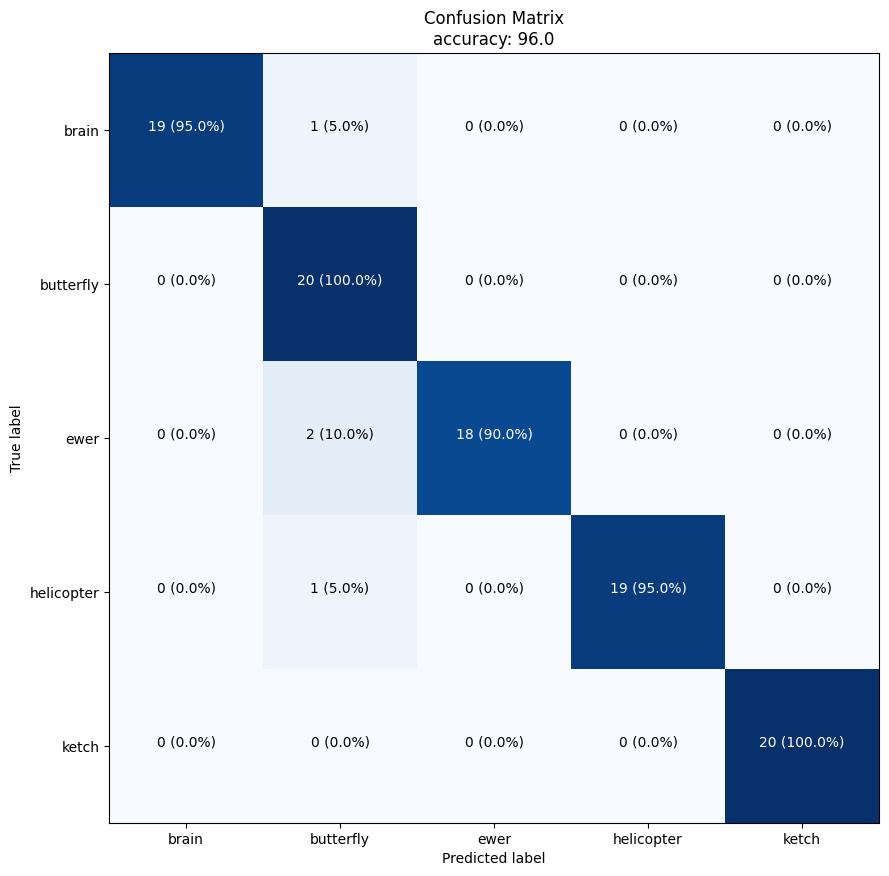

In [83]:
print('                    |------------------- confusion matrix for test datasets --------------|')
print()
plot_confusion_matrix(test_ds, class_names)

###